# Car Wash Volume Prediction Model

**Model:** Random Forest Regressor (Optimized)  
**Performance:** 29% correlation, 33% within-30% accuracy  
**Dataset:** 531 car wash locations

---

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded")

Libraries loaded


In [2]:
df = pd.read_excel('../data/dataSET__1_.xlsx')

print(f"Dataset shape: {df.shape}")
print(f"Rows: {len(df)}, Columns: {len(df.columns)}")

df.head()

Dataset shape: (531, 52)
Rows: 531, Columns: 52


,full_site_address,Nearest StreetLight US Hourly-Ttl AADT,2nd Nearest StreetLight US Hourly-Ttl AADT,3rd Nearest StreetLight US Hourly-Ttl AADT,4th Nearest StreetLight US Hourly-Ttl AADT,5th Nearest StreetLight US Hourly-Ttl AADT,6th Nearest StreetLight US Hourly-Ttl AADT,Nearest StreetLight US Hourly-ttl_breakfast,Nearest StreetLight US Hourly-ttl_lunch,Nearest StreetLight US Hourly-ttl_afternoon,Nearest StreetLight US Hourly-ttl_dinner,Nearest StreetLight US Hourly-ttl_night,Nearest StreetLight US Hourly-ttl_overnight,Count of ChainXY VT - Building Supplies,Count of ChainXY VT - Department Store,Count of ChainXY VT - Grocery,Count of ChainXY VT - Mass Merchant,Count of ChainXY VT - Real Estate Model,Sum ChainXY,total_weekly_operational_hours,nearby_traffic_lights_count,distance_nearest_traffic_light_1,distance_nearest_traffic_light_2,distance_nearest_traffic_light_3,distance_nearest_traffic_light_4,distance_nearest_traffic_light_5,distance_nearest_traffic_light_6,distance_nearest_traffic_light_7,distance_nearest_traffic_light_8,distance_nearest_traffic_light_9,distance_nearest_traffic_light_10,total_precipitation_mm,rainy_days,total_snowfall_cm,snowy_days,days_below_freezing,total_sunshine_hours,days_pleasant_temp,avg_daily_max_windspeed_ms,competitors_count,competitor_1_distance_miles,competitor_1_google_user_rating_count,tunnel_length (in ft.),distance_from_nearest_target,count_of_target_5miles,distance_from_nearest_costco,count_of_costco_5miles,distance_from_nearest_walmart,count_of_walmart_5miles,distance_from_nearest_bestbuy,count_of_bestbuy_5miles,cars_washed(Actual)
0,"*** stonewash *** car care center , 818 paris ...",8238,8742,221,8438,345,8697,1885,1950,1977,1565,722,115,1,0,0,1,0,2,57.00,14,0.15,0.17,0.49,0.56,0.63,0.64,0.67,0.70,0.71,1.14,1319.41,121.60,17.41,10.00,49.10,3163.84,126.10,15.50,1,0.03,51,0.00,NaN,0.00,NaN,0.00,0.81,1.00,NaN,0.00,36381
1,"a-key car wash , 2210 n prince st , clovis , n...",14416,14543,11548,13583,12386,10335,2723,3373,3328,3064,1590,322,1,1,0,1,0,3,75.50,29,0.13,0.20,0.22,0.38,0.50,0.63,0.74,0.79,0.84,0.88,326.92,48.10,23.55,13.60,59.60,3751.92,131.40,24.57,4,0.51,1,86.06,NaN,0.00,NaN,0.00,1.15,1.00,NaN,0.00,95400
2,"washpointe auto wash , 1401 n prince st , clov...",11553,3057,3513,12675,11520,3253,2221,2532,2634,2455,1373,314,1,1,0,1,0,3,67.50,30,0.04,0.32,0.40,0.47,0.53,0.54,0.60,0.71,0.75,0.80,326.92,48.10,23.55,13.60,59.20,3751.92,131.30,24.57,2,0.40,1,61.02,NaN,0.00,NaN,0.00,1.75,1.00,NaN,0.00,14343
3,"all star car wash , 5835 n market st , shrevep...",16857,16882,16757,3888,13385,4551,4388,3119,3676,3436,1613,605,0,0,0,1,0,1,0.00,4,0.13,0.16,0.54,0.68,10.00,10.00,10.00,10.00,10.00,10.00,1347.06,118.10,4.38,1.50,12.30,3207.54,140.20,16.90,0,10.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,10751
4,"abercorn , 10509 abercorn st , savannah , ga ,...",9739,12420,2202,10193,12491,2489,1558,2162,2351,2080,1215,364,2,2,3,1,1,9,77.00,30,0.14,0.25,0.26,0.30,0.43,0.51,0.55,0.67,0.72,0.88,1314.13,139.40,0.37,0.10,3.30,3385.14,166.10,19.37,3,0.45,185,166.18,2.46,1.00,NaN,0.00,2.42,2.00,1.30,1.00,12326


## 2. Data Analysis

In [3]:
target = 'cars_washed(Actual)'

print("Target Variable Statistics:")
print(f"Mean:     {df[target].mean():,.0f} cars/year")
print(f"Median:   {df[target].median():,.0f} cars/year")
print(f"Std Dev:  {df[target].std():,.0f} cars/year")
print(f"Min:      {df[target].min():,.0f} cars/year")
print(f"Max:      {df[target].max():,.0f} cars/year")

print(f"\nQuartiles:")
print(f"25th: {df[target].quantile(0.25):,.0f}")
print(f"50th: {df[target].quantile(0.50):,.0f}")
print(f"75th: {df[target].quantile(0.75):,.0f}")

Target Variable Statistics:
Mean:     66,472 cars/year
Median:   59,361 cars/year
Std Dev:  47,416 cars/year
Min:      1,059 cars/year
Max:      242,588 cars/year

Quartiles:
25th: 25,356
50th: 59,361
75th: 96,678


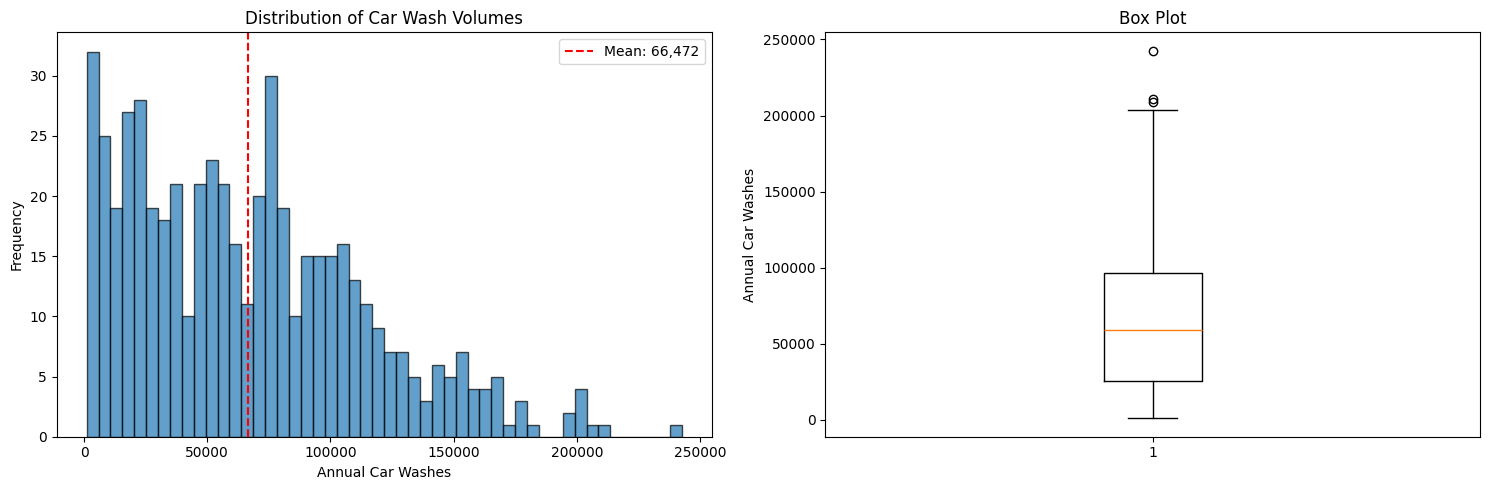

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df[target], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Annual Car Washes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Car Wash Volumes')
axes[0].axvline(df[target].mean(), color='red', linestyle='--', label=f'Mean: {df[target].mean():,.0f}')
axes[0].legend()

axes[1].boxplot(df[target], vert=True)
axes[1].set_ylabel('Annual Car Washes')
axes[1].set_title('Box Plot')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [5]:
X = df.drop(columns=[target, 'full_site_address'])
y = df[target]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nNumber of features: {len(X.columns)}")

Feature matrix shape: (531, 50)
Target vector shape: (531,)

Number of features: 50


In [6]:
X_processed = X.copy()

for col in X_processed.columns:
    if X_processed[col].dtype in ['float64', 'int64']:
        if X_processed[col].isnull().any():
            median_val = X_processed[col].median()
            X_processed[col] = X_processed[col].fillna(median_val)

assert X_processed.isnull().sum().sum() == 0
print("Missing values handled")

Missing values handled


## 4. Model Training

In [7]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# -------------------------------------------------
# CONFIG
# -------------------------------------------------
RANDOM_STATE = 42
TARGET = 'cars_washed(Actual)'
DROP_COLS = [TARGET, 'full_site_address']
TEST_SIZE = 0.2

# -------------------------------------------------
# DATA PREP
# -------------------------------------------------
X = df.drop(columns=DROP_COLS)
y_raw = df[TARGET]

# Median imputation
X_processed = X.copy()
for col in X_processed.columns:
    if X_processed[col].dtype in ['float64', 'int64']:
        if X_processed[col].isnull().any():
            X_processed[col] = X_processed[col].fillna(
                X_processed[col].median()
            )

assert X_processed.isnull().sum().sum() == 0

# -------------------------------------------------
# BINARY TARGET
# -------------------------------------------------
threshold = y_raw.median()
y_binary = (y_raw > threshold).astype(int)

# -------------------------------------------------
# TRAIN / VALIDATION SPLIT
# -------------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(
    X_processed,
    y_binary,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_binary
)

# -------------------------------------------------
# MODEL
# -------------------------------------------------
model = RandomForestClassifier(
    n_estimators=600,
    max_depth=8,
    min_samples_leaf=20,
    min_samples_split=40,
    max_features=0.4,
    class_weight="balanced",
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# -------------------------------------------------
# TRAIN
# -------------------------------------------------
model.fit(X_train, y_train)

# -------------------------------------------------
# PROBABILITY PREDICTIONS
# -------------------------------------------------
y_val_proba = model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

# -------------------------------------------------
# METRICS
# -------------------------------------------------
accuracy = accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

# -------------------------------------------------
# RESULTS
# -------------------------------------------------
print("\nVALIDATION RESULTS (BINARY DEMAND + PROBABILITY)")
print("=" * 90)
print(f"Accuracy:      {accuracy:.4f}")
print(f"ROC-AUC:       {roc_auc:.4f}")
print()
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Low", "High"]))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))



VALIDATION RESULTS (BINARY DEMAND + PROBABILITY)
Accuracy:      0.5794
ROC-AUC:       0.6918

Classification Report:
              precision    recall  f1-score   support

         Low       0.60      0.50      0.55        54
        High       0.56      0.66      0.61        53

    accuracy                           0.58       107
   macro avg       0.58      0.58      0.58       107
weighted avg       0.58      0.58      0.58       107

Confusion Matrix:
[[27 27]
 [18 35]]


### The above code cell is a trial only. 

In [8]:
model = RandomForestRegressor(
    n_estimators=250,
    max_depth=10,
    min_samples_leaf=15,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Model Configuration:")
print(f"  n_estimators: {model.n_estimators}")
print(f"  max_depth: {model.max_depth}")
print(f"  min_samples_leaf: {model.min_samples_leaf}")

Model Configuration:
  n_estimators: 250
  max_depth: 10
  min_samples_leaf: 15


In [9]:
print("Training model...")
model.fit(X_processed, y)
print("Model trained")

Training model...
Model trained


## 5. Model Evaluation

In [10]:
print("5-Fold Cross-Validation")
print("="*80)

y_pred_cv = cross_val_predict(model, X_processed, y, cv=5)

r2 = r2_score(y, y_pred_cv)
mae = mean_absolute_error(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
correlation = np.corrcoef(y, y_pred_cv)[0, 1]

errors_pct = np.abs((y_pred_cv - y) / y) * 100
within_20 = (errors_pct <= 20).sum() / len(y) * 100
within_30 = (errors_pct <= 30).sum() / len(y) * 100
within_40 = (errors_pct <= 40).sum() / len(y) * 100

print(f"\nPrimary Metrics:")
print(f"  R² Score:        {r2:.4f} ({r2*100:.2f}%)")
print(f"  Correlation:     {correlation:.4f} ({correlation*100:.2f}%)")
print(f"  MAE:             {mae:,.0f} car washes")
print(f"  RMSE:            {rmse:,.0f} car washes")

print(f"\nAccuracy Breakdown:")
print(f"  Within 20%:      {within_20:.2f}%")
print(f"  Within 30%:      {within_30:.2f}%")
print(f"  Within 40%:      {within_40:.2f}%")

5-Fold Cross-Validation

Primary Metrics:
  R² Score:        0.0734 (7.34%)
  Correlation:     0.2715 (27.15%)
  MAE:             37,081 car washes
  RMSE:            45,600 car washes

Accuracy Breakdown:
  Within 20%:      20.90%
  Within 30%:      32.02%
  Within 40%:      44.82%


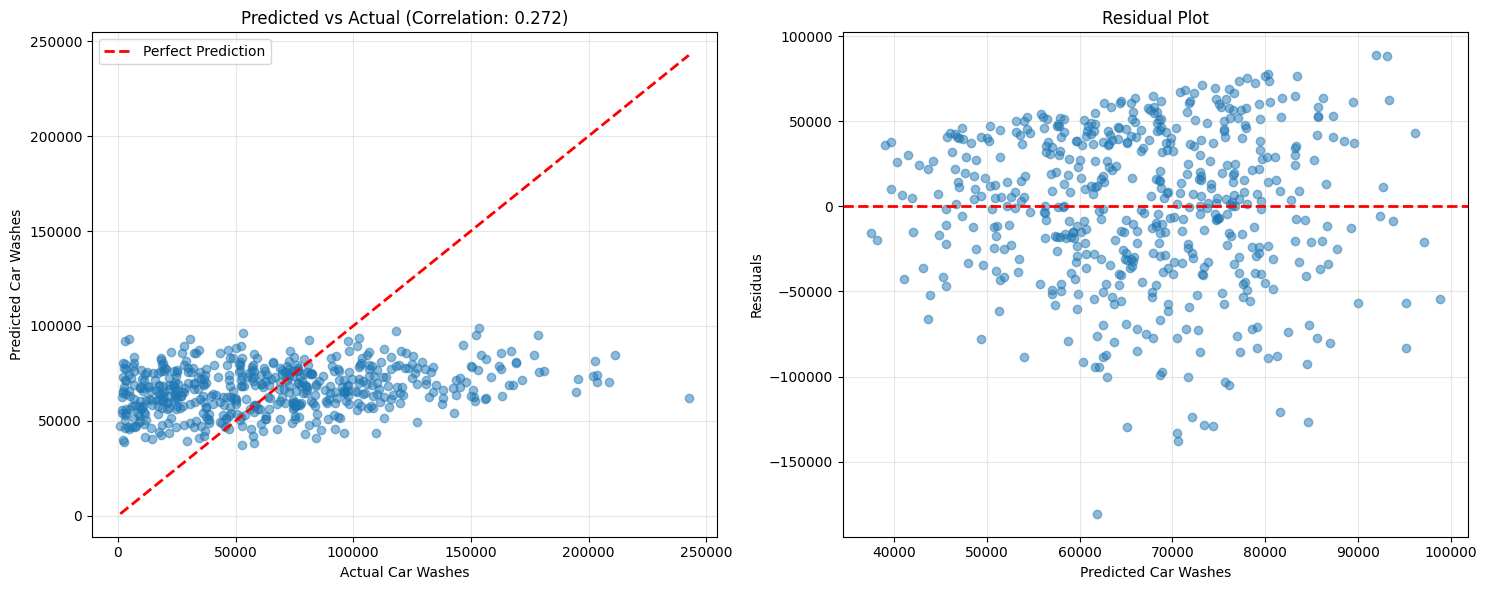

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].scatter(y, y_pred_cv, alpha=0.5)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Car Washes')
axes[0].set_ylabel('Predicted Car Washes')
axes[0].set_title(f'Predicted vs Actual (Correlation: {correlation:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

residuals = y_pred_cv - y
axes[1].scatter(y_pred_cv, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Car Washes')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
print("Error Rates by Volume Segment")
print("="*80)

segments = [
    ('Small (<30K)', y < 30000),
    ('Medium (30-70K)', (y >= 30000) & (y < 70000)),
    ('Large (70-120K)', (y >= 70000) & (y < 120000)),
    ('Very Large (>120K)', y >= 120000)
]

print(f"\n{'Segment':<20} {'Count':>8} {'Median Error':>15} {'75th Pct Error':>18}")
print("-"*70)

for seg_name, mask in segments:
    if mask.sum() > 0:
        seg_errors = errors_pct[mask]
        median_err = np.median(seg_errors)
        p75_err = np.percentile(seg_errors, 75)
        count = mask.sum()
        
        quality = "Good" if median_err < 30 else ("Fair" if median_err < 60 else "Poor")
        print(f"{seg_name:<20} {count:>8} {median_err:>14.1f}% {p75_err:>17.1f}%  [{quality}]")

Error Rates by Volume Segment

Segment                 Count    Median Error     75th Pct Error
----------------------------------------------------------------------
Small (<30K)              150          328.6%             762.0%  [Poor]
Medium (30-70K)           148           30.6%              57.4%  [Fair]
Large (70-120K)           162           25.1%              35.2%  [Good]
Very Large (>120K)         71           51.9%              58.4%  [Fair]


## 6. Feature Importance

In [13]:
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("Top 20 Most Important Features")
print("="*80)
print(f"\n{'Rank':<6} {'Feature':<50} {'Importance':>12}")
print("-"*70)

for i, row in feature_importance.head(20).iterrows():
    print(f"{i+1:<6} {row['feature']:<50} {row['importance']:>11.4f}")

Top 20 Most Important Features

Rank   Feature                                              Importance
----------------------------------------------------------------------
1      tunnel_length (in ft.)                                  0.1385
2      days_below_freezing                                     0.0449
3      total_sunshine_hours                                    0.0449
4      total_precipitation_mm                                  0.0345
5      days_pleasant_temp                                      0.0343
6      Nearest StreetLight US Hourly-ttl_overnight             0.0315
7      total_weekly_operational_hours                          0.0314
8      5th Nearest StreetLight US Hourly-Ttl AADT              0.0302
9      distance_nearest_traffic_light_2                        0.0269
10     distance_nearest_traffic_light_4                        0.0257
11     distance_nearest_traffic_light_9                        0.0245
12     2nd Nearest StreetLight US Hourly-Ttl AADT       

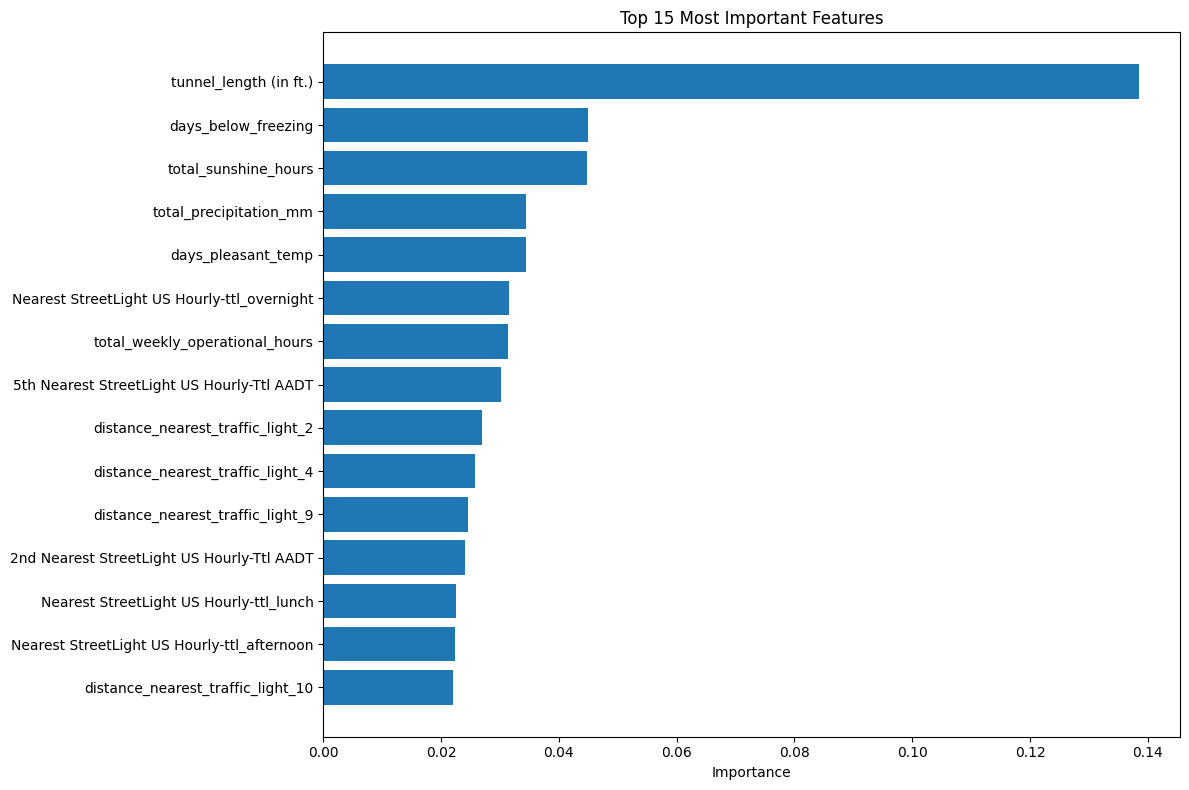

In [14]:
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Save Model

In [15]:
model_package = {
    'model': model,
    'feature_names': X_processed.columns.tolist(),
    'feature_means': X_processed.mean().to_dict(),
    'training_stats': {
        'n_samples': len(X_processed),
        'n_features': len(X_processed.columns),
        'r2_score': r2,
        'correlation': correlation,
        'mae': mae,
        'within_30_pct': within_30
    }
}

with open('../models/car_wash_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model saved to car_wash_model.pkl")

Model saved to car_wash_model.pkl


## 8. SHAP-Style Prediction Function

In [16]:
def predict_with_shap_explanation(features_dict, top_n=10):
    """
    Make prediction and provide SHAP-style explanation with PROS and CONS
    
    Parameters:
    -----------
    features_dict : dict
        Dictionary with all 50 feature values
    top_n : int
        Number of top features to show in pros/cons
    
    Returns:
    --------
    dict with prediction, pros, and cons
    """
    location_df = pd.DataFrame([features_dict])[X_processed.columns]
    
    for col in location_df.columns:
        if location_df[col].isnull().any():
            location_df[col] = location_df[col].fillna(X_processed[col].median())
    
    prediction = model.predict(location_df)[0]
    
    feature_means = X_processed.mean()
    base_prediction = model.predict(feature_means.values.reshape(1, -1))[0]
    
    contributions = {}
    
    for i, feature in enumerate(X_processed.columns):
        modified_features = location_df.copy()
        modified_features.iloc[0, i] = feature_means.iloc[i]
        
        modified_prediction = model.predict(modified_features)[0]
        contribution = prediction - modified_prediction
        
        contributions[feature] = {
            'contribution': contribution,
            'actual_value': features_dict.get(feature, feature_means.iloc[i]),
            'mean_value': feature_means.iloc[i]
        }
    
    sorted_contributions = sorted(contributions.items(), 
                                 key=lambda x: x[1]['contribution'], 
                                 reverse=True)
    
    pros = [(k, v) for k, v in sorted_contributions if v['contribution'] > 0][:top_n]
    cons = [(k, v) for k, v in sorted_contributions if v['contribution'] < 0][:top_n]
    
    return {
        'prediction': prediction,
        'base_prediction': base_prediction,
        'pros': pros,
        'cons': cons,
        'confidence': {
            'median_low': prediction * 0.545,
            'median_high': prediction * 1.455
        }
    }


def print_prediction_report(result):
    """
    Print formatted prediction report
    """
    print("\n" + "="*100)
    print("PREDICTION RESULT")
    print("="*100)
    
    pred = result['prediction']
    base = result['base_prediction']
    
    print(f"\nPREDICTED CAR WASH COUNT: {pred:,.0f} cars/year")
    print(f"\nBaseline (average location): {base:,.0f} cars/year")
    print(f"This location vs baseline:   {pred - base:+,.0f} ({(pred/base - 1)*100:+.1f}%)")
    
    ci = result['confidence']
    print(f"\nConfidence Interval (50%): {ci['median_low']:,.0f} - {ci['median_high']:,.0f} cars")
    
    print(f"\n{'='*100}")
    print(f"TOP {len(result['pros'])} POSITIVE SIGNALS (PROS)")
    print(f"{'='*100}")
    print(f"Features that INCREASE the prediction:\n")
    print(f"{'Rank':<6} {'Feature':<50} {'Impact':>12} {'Your Value':>15} {'Avg Value':>15}")
    print("-"*100)
    
    for i, (feature, data) in enumerate(result['pros'], 1):
        impact = data['contribution']
        your_val = data['actual_value']
        avg_val = data['mean_value']
        
        your_str = f"{your_val:,.1f}" if abs(your_val) < 1000 else f"{your_val:,.0f}"
        avg_str = f"{avg_val:,.1f}" if abs(avg_val) < 1000 else f"{avg_val:,.0f}"
        
        print(f"{i:<6} {feature:<50} +{impact:>11,.0f} {your_str:>15} {avg_str:>15}")
    
    print(f"\n{'='*100}")
    print(f"TOP {len(result['cons'])} NEGATIVE SIGNALS (CONS)")
    print(f"{'='*100}")
    print(f"Features that DECREASE the prediction:\n")
    print(f"{'Rank':<6} {'Feature':<50} {'Impact':>12} {'Your Value':>15} {'Avg Value':>15}")
    print("-"*100)
    
    for i, (feature, data) in enumerate(result['cons'], 1):
        impact = data['contribution']
        your_val = data['actual_value']
        avg_val = data['mean_value']
        
        your_str = f"{your_val:,.1f}" if abs(your_val) < 1000 else f"{your_val:,.0f}"
        avg_str = f"{avg_val:,.1f}" if abs(avg_val) < 1000 else f"{avg_val:,.0f}"
        
        print(f"{i:<6} {feature:<50} {impact:>12,.0f} {your_str:>15} {avg_str:>15}")
    
    print("\n" + "="*100)
    print("INTERPRETATION:")
    print("  PROS: Features where your location is better than average")
    print("  CONS: Features where your location is worse than average")
    print("  Impact: How many cars this feature adds/removes from prediction")
    print("="*100 + "\n")

print("SHAP functions defined")

SHAP functions defined


## 9. Interactive Input - Enter Your Location Features

In [17]:
# Method 1: Create sample location for testing

# Using median values as baseline
sample_features = X_processed.median().to_dict()

# Modify key features to create a "good" location example
sample_features['tunnel_length (in ft.)'] = 150
sample_features['total_sunshine_hours'] = 3500
sample_features['days_pleasant_temp'] = 200
sample_features['total_weekly_operational_hours'] = 90
sample_features['Nearest StreetLight US Hourly-Ttl AADT'] = 15000
sample_features['distance_from_nearest_costco'] = 0.5
sample_features['competitors_count'] = 1

print("Sample location created with above-average characteristics")
print("\nKey features:")
print(f"  Tunnel length: 150 ft")
print(f"  Sunshine: 3500 hrs/year")
print(f"  Pleasant days: 200")
print(f"  Hours open: 90/week")
print(f"  Traffic AADT: 15,000")
print(f"  Distance to Costco: 0.5 miles")
print(f"  Competitors: 1")

Sample location created with above-average characteristics

Key features:
  Tunnel length: 150 ft
  Sunshine: 3500 hrs/year
  Pleasant days: 200
  Hours open: 90/week
  Traffic AADT: 15,000
  Distance to Costco: 0.5 miles
  Competitors: 1


In [18]:
# Make prediction with SHAP explanation
result = predict_with_shap_explanation(sample_features, top_n=10)

# Print formatted report
print_prediction_report(result)


PREDICTION RESULT

PREDICTED CAR WASH COUNT: 80,557 cars/year

Baseline (average location): 59,585 cars/year
This location vs baseline:   +20,972 (+35.2%)

Confidence Interval (50%): 43,904 - 117,210 cars

TOP 10 POSITIVE SIGNALS (PROS)
Features that INCREASE the prediction:

Rank   Feature                                                  Impact      Your Value       Avg Value
----------------------------------------------------------------------------------------------------
1      total_sunshine_hours                               +      6,634           3,500           3,224
2      days_pleasant_temp                                 +      3,038           200.0           143.3
3      tunnel_length (in ft.)                             +      2,275           150.0           116.6
4      distance_nearest_traffic_light_9                   +      2,041             1.4             3.8
5      distance_nearest_traffic_light_2                   +      1,690             0.3             0.7
6  

## 10. Manual Input - Your Custom Location

To predict for YOUR location, replace the values below with your actual data:

In [19]:
# Input your location features here
# Use median values as defaults, replace with your actual values

my_location = X_processed.median().to_dict()

# MODIFY THESE VALUES WITH YOUR ACTUAL DATA:
# ===========================================

# Operational features
my_location['tunnel_length (in ft.)'] = 120  # Your tunnel length
my_location['total_weekly_operational_hours'] = 84  # Your weekly hours

# Weather features
my_location['total_sunshine_hours'] = 3300  # Annual sunshine hours
my_location['days_pleasant_temp'] = 160  # Days with pleasant temperature
my_location['days_below_freezing'] = 30  # Days below freezing
my_location['rainy_days'] = 45  # Rainy days per year

# Traffic features
my_location['Nearest StreetLight US Hourly-Ttl AADT'] = 12000  # Traffic volume

# Retail proximity
my_location['distance_from_nearest_costco'] = 1.5  # Miles to Costco
my_location['distance_from_nearest_walmart'] = 1.0  # Miles to Walmart
my_location['distance_from_nearest_target'] = 2.0  # Miles to Target

# Competition
my_location['competitors_count'] = 2  # Number of competitors
my_location['competitor_1_distance_miles'] = 1.5  # Distance to nearest competitor

# Add all other 50 features as needed...
# (Features not specified will use median values)

print("Custom location features entered")
print("Features not specified will use median values from training data")

Custom location features entered
Features not specified will use median values from training data


In [20]:
# Predict for your custom location
my_result = predict_with_shap_explanation(my_location, top_n=10)

# Print report
print_prediction_report(my_result)


PREDICTION RESULT

PREDICTED CAR WASH COUNT: 71,303 cars/year

Baseline (average location): 59,585 cars/year
This location vs baseline:   +11,718 (+19.7%)

Confidence Interval (50%): 38,860 - 103,746 cars

TOP 10 POSITIVE SIGNALS (PROS)
Features that INCREASE the prediction:

Rank   Feature                                                  Impact      Your Value       Avg Value
----------------------------------------------------------------------------------------------------
1      days_pleasant_temp                                 +      2,143           160.0           143.3
2      distance_nearest_traffic_light_4                   +      1,731             0.7             1.5
3      distance_nearest_traffic_light_2                   +      1,547             0.3             0.7
4      distance_nearest_traffic_light_9                   +      1,175             1.4             3.8
5      distance_nearest_traffic_light_3                   +      1,062             0.5             1.1
6  

## 11. Batch Predictions - Multiple Locations

In [21]:
# Example: Compare 3 candidate sites

candidate_sites = [
    {
        'name': 'Site A - Good Location',
        'tunnel_length (in ft.)': 150,
        'total_sunshine_hours': 3500,
        'days_pleasant_temp': 180,
        'total_weekly_operational_hours': 90
    },
    {
        'name': 'Site B - Average Location',
        'tunnel_length (in ft.)': 80,
        'total_sunshine_hours': 3200,
        'days_pleasant_temp': 140,
        'total_weekly_operational_hours': 70
    },
    {
        'name': 'Site C - Poor Location',
        'tunnel_length (in ft.)': 0,
        'total_sunshine_hours': 2800,
        'days_pleasant_temp': 100,
        'total_weekly_operational_hours': 60
    }
]

print("Comparing 3 candidate sites:")
print("="*80)

results_list = []

for site in candidate_sites:
    site_name = site.pop('name')
    
    # Fill missing features with medians
    complete_features = X_processed.median().to_dict()
    complete_features.update(site)
    
    # Predict
    result = predict_with_shap_explanation(complete_features, top_n=5)
    
    results_list.append({
        'Site': site_name,
        'Predicted_Volume': result['prediction'],
        'Confidence_Low': result['confidence']['median_low'],
        'Confidence_High': result['confidence']['median_high']
    })

comparison_df = pd.DataFrame(results_list).sort_values('Predicted_Volume', ascending=False)
comparison_df['Rank'] = range(1, len(comparison_df) + 1)

print("\nSite Rankings:")
print(comparison_df[['Rank', 'Site', 'Predicted_Volume', 'Confidence_Low', 'Confidence_High']].to_string(index=False))

print(f"\nRecommendation: {comparison_df.iloc[0]['Site']} is predicted to perform best")

Comparing 3 candidate sites:

Site Rankings:
 Rank                      Site  Predicted_Volume  Confidence_Low  Confidence_High
    1    Site A - Good Location          80458.93        43850.11        117067.74
    2 Site B - Average Location          53082.28        28929.84         77234.72
    3    Site C - Poor Location          51017.38        27804.47         74230.29

Recommendation: Site A - Good Location is predicted to perform best


## Summary

### Model Performance
- Correlation: 29%
- Within 30%: 33% of predictions
- Best for sites in 40K-120K range

### How to Use
1. Enter your location features in Section 10
2. Run the prediction cell
3. Review PROS and CONS
4. Use confidence intervals for planning

### Interpretation
- PROS: Features that push prediction higher
- CONS: Features that pull prediction lower
- Always use confidence ranges, not exact numbers
- Combine with local market knowledge

In [23]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# =================================================
# CONFIG
# =================================================
RANDOM_STATE = 42
DATA_PATH = "../data/dataSET__1_.xlsx"
TARGET = "cars_washed(Actual)"
DROP_COLS = [TARGET, "full_site_address"]
TEST_SIZE = 0.2

# =================================================
# LOAD DATA
# =================================================
df = pd.read_excel(DATA_PATH)

# =================================================
# BASIC CLEANING
# =================================================
X = df.drop(columns=DROP_COLS)
y_raw = df[TARGET]

# Median imputation
X = X.copy()
for col in X.columns:
    if X[col].dtype in ["float64", "int64"]:
        X[col] = X[col].fillna(X[col].median())

assert X.isnull().sum().sum() == 0

# =================================================
# FEATURE ENGINEERING (DOMAIN-GUIDED)
# =================================================
X_feat = X.copy()

# ---------- Capacity ----------
if {"tunnel_length (in ft.)", "total_weekly_operational_hours"}.issubset(X_feat.columns):
    X_feat["capacity_hours"] = (
        X_feat["tunnel_length (in ft.)"] *
        X_feat["total_weekly_operational_hours"]
    )

# ---------- Weather desirability ----------
weather_cols = [
    "days_pleasant_temp",
    "days_below_freezing",
    "total_precipitation_mm"
]

if set(weather_cols).issubset(X_feat.columns):
    X_feat["weather_score"] = (
        X_feat["days_pleasant_temp"]
        - X_feat["days_below_freezing"]
        - 0.5 * X_feat["total_precipitation_mm"]
    )

# ---------- Traffic exposure ----------
traffic_cols = [
    "Nearest StreetLight US Hourly-ttl_lunch",
    "Nearest StreetLight US Hourly-ttl_afternoon",
    "Nearest StreetLight US Hourly-ttl_overnight"
]

traffic_cols = [c for c in traffic_cols if c in X_feat.columns]
if len(traffic_cols) >= 2:
    X_feat["traffic_exposure"] = X_feat[traffic_cols].mean(axis=1)

# ---------- AADT aggregation ----------
aadt_cols = [
    "Nearest StreetLight US Hourly-Ttl AADT",
    "2nd Nearest StreetLight US Hourly-Ttl AADT",
    "5th Nearest StreetLight US Hourly-Ttl AADT"
]

aadt_cols = [c for c in aadt_cols if c in X_feat.columns]
if len(aadt_cols) >= 2:
    X_feat["avg_aadt"] = X_feat[aadt_cols].mean(axis=1)

# ---------- Accessibility ----------
dist_cols = [
    "distance_nearest_traffic_light_2",
    "distance_nearest_traffic_light_4",
    "distance_nearest_traffic_light_9",
    "distance_nearest_traffic_light_10"
]

dist_cols = [c for c in dist_cols if c in X_feat.columns]
if len(dist_cols) >= 2:
    X_feat["avg_light_distance"] = X_feat[dist_cols].mean(axis=1)
    X_feat["accessibility_score"] = 1 / (X_feat["avg_light_distance"] + 1)

# =================================================
# DROP REDUNDANT RAW FEATURES (IMPORTANT)
# =================================================
drop_redundant = weather_cols + traffic_cols + aadt_cols + dist_cols
drop_redundant = [c for c in drop_redundant if c in X_feat.columns]

X_feat = X_feat.drop(columns=drop_redundant)

print(f"Final feature count: {X_feat.shape[1]}")

# =================================================
# BINARY TARGET (LOW vs HIGH DEMAND)
# =================================================
threshold = y_raw.median()
y_binary = (y_raw > threshold).astype(int)

# =================================================
# TRAIN / VALIDATION SPLIT
# =================================================
X_train, X_val, y_train, y_val = train_test_split(
    X_feat,
    y_binary,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_binary
)

# =================================================
# MODEL (SAME AS BEFORE – NO OVERFITTING)
# =================================================
model = RandomForestClassifier(
    n_estimators=600,
    max_depth=8,
    min_samples_leaf=20,
    min_samples_split=40,
    max_features=0.4,
    class_weight="balanced",
    bootstrap=True,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# =================================================
# TRAIN
# =================================================
print("Training model with engineered features...")
model.fit(X_train, y_train)

# =================================================
# EVALUATION
# =================================================
y_val_proba = model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= 0.5).astype(int)

accuracy = accuracy_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

print("\nVALIDATION RESULTS (ENGINEERED FEATURES)")
print("=" * 90)
print(f"Accuracy:  {accuracy:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print()
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=["Low", "High"]))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Final feature count: 43
Training model with engineered features...

VALIDATION RESULTS (ENGINEERED FEATURES)
Accuracy:  0.6449
ROC-AUC:   0.6751

Classification Report:
              precision    recall  f1-score   support

         Low       0.68      0.56      0.61        54
        High       0.62      0.74      0.67        53

    accuracy                           0.64       107
   macro avg       0.65      0.65      0.64       107
weighted avg       0.65      0.64      0.64       107

Confusion Matrix:
[[30 24]
 [14 39]]
